In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

import tensorflow_addons as tfa

In [ ]:
import sys
sys.path.append('..')

In [ ]:
best_model = tf.keras.models.load_model('../20220603_icsd_and_battery_combined/best_model/', compile=False)

In [ ]:
import pandas as pd

In [ ]:
backtest_data = pd.read_pickle('/projects/rlmolecule/jlaw/crystal_outputs/2022_05_17_combined.p')

In [12]:
from preprocess import preprocessor
import numpy as np


def preprocess_structure(structure):
    inputs = preprocessor(structure, train=True)

    # scale structures to a minimum of 1A interatomic distance
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        warn(f"Error with {row.id}")
        return None

    scale_factor = 1.0 / inputs["distance"].min()
    inputs["distance"] *= scale_factor
    inputs["input_vol"] = (structure.volume / structure.num_sites) * scale_factor**3
    inputs["true_vol"] = np.nan
    return inputs


dataset = (
    tf.data.Dataset.from_generator(
        lambda: (preprocess_structure(struc) for struc in backtest_data.unrel_structure),
        output_signature={
            **preprocessor.output_signature,
            "input_vol": tf.TensorSpec(shape=(), dtype=tf.float32),
            "true_vol": tf.TensorSpec(shape=(), dtype=tf.float32),
        },
    )
    .padded_batch(
        batch_size=128,
        padding_values={
            **preprocessor.padding_values,
            "input_vol": tf.constant(np.nan, dtype=tf.float32),
            "true_vol": tf.constant(np.nan, dtype=tf.float32),
        },
    )
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [13]:
predictions = best_model.predict(dataset, verbose=1)

11/11 [==============================] - 25s 2s/step


In [14]:
backtest_data['psj_pred_vol'] = predictions[0].flatten() * backtest_data['unrel_structure'].apply(lambda x: x.num_sites)

In [15]:
backtest_data['psj_pred_energy'] = predictions[1].flatten()

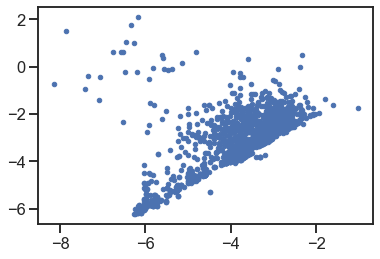

In [16]:
plt.plot(backtest_data.energyperatom, backtest_data.psj_pred_energy, '.')

In [17]:
import nfp

In [18]:
from nfp.layers import RBFExpansion

In [19]:
energy_direct_model = tf.keras.models.load_model(
    '../20220603_icsd_and_battery/best_model.hdf5',
    custom_objects={**nfp.custom_objects, **{'RBFExpansion': RBFExpansion}},
    compile=False)

def preprocess_energy(structure):
    inputs = preprocessor(structure, train=True)

    # scale structures to a minimum of 1A interatomic distance
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        warn(f"Error with {row.id}")
        return None

    scale_factor = 1.0 / inputs["distance"].min()
    inputs["distance"] *= scale_factor
    return inputs


dataset = (
    tf.data.Dataset.from_generator(
        lambda: (preprocess_energy(structure) for structure in backtest_data.unrel_structure),
        output_signature=preprocessor.output_signature,
    )
    .padded_batch(batch_size=128, padding_values=preprocessor.padding_values)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [20]:
energy_predictions = energy_direct_model.predict(dataset, verbose=1)

11/11 [==============================] - 26s 2s/step


In [21]:
backtest_data['psj_pred_energy_direct'] = energy_predictions

In [25]:
backtest_data['my_err'] = (backtest_data.energyperatom - backtest_data.psj_pred_energy).abs()
backtest_data['my_err2'] = (backtest_data.energyperatom - backtest_data.psj_pred_energy_direct).abs()
backtest_data['jl_err'] = (backtest_data.energyperatom - backtest_data.pred_energyperatom).abs()

backtest_data.groupby('run_id')[['my_err', 'my_err2', 'jl_err']].mean()

,my_err,my_err2,jl_err
run_id,,,
2022-01-18-run1,0.315099,0.335341,0.342441
2022-01-21-run2-3,0.316372,0.307951,0.345054
2022-01-25-run4,2.937766,3.060188,3.194721
2022-04-26-batt-icsd-vol-combined,1.469706,1.482761,1.486551
2022-04-27-batt-icsd-vol-combined,0.635307,0.625097,0.617391
20220504/batt-icsd-volpred-KLiNa,0.053559,0.048379,0.054597
20220504/batt-volpred-KLiNa,0.398296,0.213140,0.408410
20220509-rel-energy-cos-dist0.1-eles3-Li,1.649818,1.804963,2.031088
